In [1]:
from utility_dnn import *
from utility_plotter import *
from utility_common import *

from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

# 0. Load Data 

In [2]:
selection  = "mumu"
nbjetcut   =  "==1"

pickledir  =  "/Users/zihengchen/Documents/Analysis/workplace/data/pickle_{}/".format(selection)
filterdir  = '../data/nnfilter/{}/'.format(selection)
zvetomask  =  "(lepton2_pt>5) & (nBJets{})".format(nbjetcut)
zvetomask +=  "& (dilepton_mass>10) & (dilepton_mass<80 | dilepton_mass>100)"
rmcollist  = ['eventWeight','nBJets','nElectrons', 'nJets', 'nMuons', 'nPV','wdecay','taudecay',
              'lepton1_q','lepton2_q','lepton1_mother','lepton2_mother',"eventWeightSF",
              'lepton1_d0', 'lepton1_dz', 'lepton2_d0','lepton2_dz']

In [3]:
Data = LoadDataframe(pickledir +"data2016").query(zvetomask)
MCzz = LoadDataframe(pickledir +"mcdiboson").query(zvetomask)
MCdy = LoadDataframe(pickledir +"mcdy").query(zvetomask)
MCt  = LoadDataframe(pickledir +"mct").query(zvetomask)
MCtt = LoadDataframe(pickledir +"mctt").query(zvetomask)
# signal mc is tt+tW
MCsg = pd.concat([MCt,MCtt],ignore_index=True)
MCsgf = MCsg[(MCsg.wdecay == 'e_')   | (MCsg.wdecay == 'mu_') | (MCsg.wdecay == 'tau_')    | (MCsg.wdecay == '_') ]
MCsg0 = MCsg[(MCsg.wdecay == 'emu_') | (MCsg.wdecay == 'ee_') | (MCsg.wdecay == 'tautau_') | (MCsg.wdecay == 'etau_')]
MCsg1 = MCsg[(MCsg.wdecay == 'mumu_')]
MCsg2 = MCsg[(MCsg.wdecay == 'mutau_')]

df_list = [MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,Data]

In [4]:
for i in range(len(df_list)):
    df_list[i] = df_list[i].reset_index(drop=True)
criterion   = nn.CrossEntropyLoss()
likelihood  = nn.Softmax()
net = torch.load(filterdir+"1b.pt")

### Go to Step 3 if already trained DNN

# 1.  Boostrap Training Set

In [5]:
SFN = np.array([177, 9683, 2116, 683, 54537, 12317])*1 #nbjet==1
SFN += np.array([25, 653, 216, 173, 16098, 3620])*1    #nbjet>1

MCzz_   = MCzz .sample(SFN[0],replace=False)
MCdy_   = MCdy .sample(SFN[1],replace=True)
MCsgf_  = MCsgf.sample(SFN[2],replace=False)
MCsg0_  = MCsg0.sample(SFN[3],replace=False)
MCsg1_  = MCsg1.sample(SFN[4],replace=False)
MCsg2_  = MCsg2.sample(SFN[5],replace=False)

MCbkg   = pd.concat([MCdy_,MCsgf_,MCsg0_,MCsg1_],ignore_index=True)
MCsig   = pd.concat([MCsg2_],ignore_index=True)
MCbkg.drop( rmcollist, axis=1, inplace=True)
MCsig.drop( rmcollist, axis=1, inplace=True)
MCbkg['label'] = 0
MCsig['label'] = 1

In [6]:
BATCHSIZE = 1000
NFeature  = 84
df_train    = pd.concat([MCbkg,MCsig],ignore_index=True)
trainset    = MyDataset(df_train.as_matrix(),NFeature)
trainloader = DataLoader(trainset, batch_size=BATCHSIZE,shuffle=True, num_workers=4)

# 2. Define DNN and Train DNN

In [7]:
net = Net(NFeature,64,32,16,2).cuda()
#net = Net_dropout(NFeature,64,32,8,2).cuda()

In [18]:
optimizer   = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
net = net.cuda()
for epoch in range(500):
    running_loss = 0.0
    for i, onebatch in enumerate(trainloader,0):
        # get the inputs
        inputs = Variable(onebatch["feature"]).cuda()
        labels = Variable(onebatch["label"]).cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]    
    clear_output(wait=True)
    print('[%d] loss: %.5f' %(epoch + 1, running_loss))

print('Finished Training')
torch.save(net.cpu(),filterdir+"checkpoint.pt")

[500] loss: 30.08170
Finished Training


# 3. Test Accuracy

In [5]:
NFeature  = 84
for idf in df_list:
    temp = idf.drop(rmcollist, axis=1)
    temp['softmax'] = np.ones(len(temp.index)).astype(int)
    tempset    = MyDataset(temp.as_matrix(),NFeature)
    
    temploader = DataLoader(tempset, batch_size=tempset.__len__(),shuffle=False, num_workers=1)
    tempiter = iter(temploader).next()
    tempinputs   = tempiter["feature"]
    templabels   = tempiter["label"]
    tempoutputs  = net(Variable(tempinputs))
    
    tempsoftmax  = likelihood(tempoutputs).data.numpy()
    tempSignalP     = tempsoftmax[:,1]
    #temppredicts = isSignal.astype(int)
    #torch.max(tempoutputs.data, 1)[1] # return likelihood, predict
    idf["softmax"] = tempSignalP

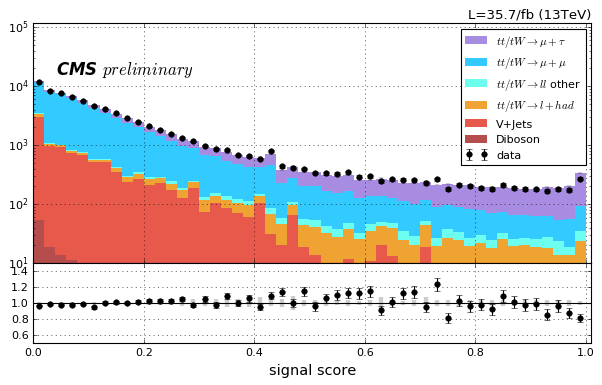

In [6]:
label_list = ['Diboson','V+Jets', r'$tt/tW \rightarrow l + had$',
              r'$tt/tW \rightarrow ll$ other ',
              r'$tt/tW \rightarrow \mu + \mu$',
              r'$tt/tW \rightarrow \mu+ \tau$',
              'data']
color_list = ["#a32020","#e0301e","#eb8c00","#49feec","deepskyblue","mediumpurple","k"]
plotoutdir = GetPlotDir(selection, nbjetcut)

plotter = SelectionPlotter("softmax",0,1.01,0.02,df_list)
plotter.settingPlot("signal score",
                   label_list,color_list,                    
                   logscale   = True,
                   isstacked  = True,
                   figuresize = (9,5))
plotter.makePlot(plotoutdir)


### 3.2 Do template fit on the score

In [7]:
from utility_templatefitter import *
tfit = TemplateFitter_Hist("softmax",0,1.01,0.02,df_list,
                          lock=np.array([1,1,0,0,0,0])
                         )


Failed for boundaries, negetive sigma^2 exist in observed inv-hessian 
total cost is  60.805685
adjust 0 is  1.000 +/-  0.000
adjust 1 is  1.000 +/-  0.000
adjust 2 is  0.000 +/-  0.000
adjust 3 is 10.000 +/-  0.000
adjust 4 is  0.995 +/-  0.000
adjust 5 is  0.640 +/-  0.000


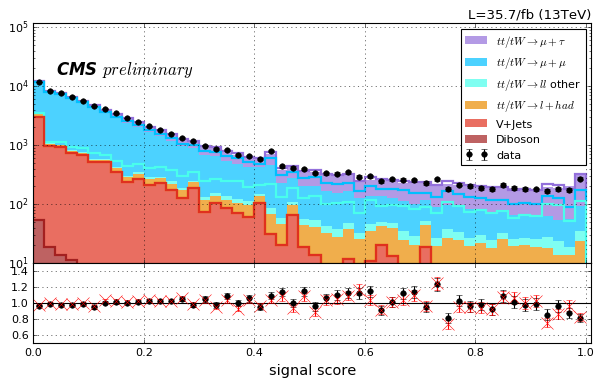

In [8]:
tfit.settingPlot("signal score",
                label_list,color_list,                    
                logscale   = True,
                isstacked  = True,
                figuresize = (9,5))
tfit.plotFittingResult()

In [7]:
NFeature  = 84
for idf in [MCsg]:
    temp = idf.drop(rmcollist, axis=1)
    temp['softmax'] = np.ones(len(temp.index)).astype(int)
    tempset    = MyDataset(temp.as_matrix(),NFeature)
    
    temploader = DataLoader(tempset, batch_size=tempset.__len__(),shuffle=False, num_workers=1)
    tempiter = iter(temploader).next()
    tempinputs   = tempiter["feature"]
    templabels   = tempiter["label"]
    tempoutputs  = net(Variable(tempinputs))
    
    tempsoftmax  = likelihood(tempoutputs).data.numpy()
    tempSignalP     = tempsoftmax[:,1]
    #temppredicts = isSignal.astype(int)
    #torch.max(tempoutputs.data, 1)[1] # return likelihood, predict
    idf["softmax"] = tempSignalP

In [8]:
MCsg.to_pickle('../data/pickle_mumu/mcsg_softmax/1b.pkl')

# 4. Apply Score Cut

In [20]:
filterdf_list = []
slt = "softmax>=0.05"
for i in range(len(df_list)):
    filterdf_list.append(df_list[i].query(slt))

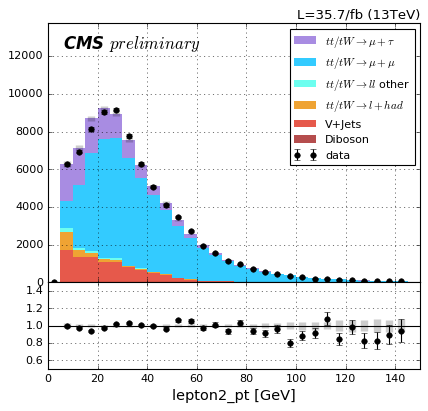

In [28]:
plotter = SelectionPlotter("lepton2_pt",0,150,5,df_list)
plotter.settingPlot("lepton2_pt [GeV]",label_list,color_list,                    
                    logscale   = False,
                    isstacked  = True,
                    figuresize = (6,5.4))
plotter.makePlot()

## Plot All Variables with the Score Cut

In [21]:
pp = pd.read_csv("plotter/plotparameters.csv")
for index, row in pp.iterrows():
    v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
    plotter = SelectionPlotter(v,a,b,step,df_list)
    plotter.settingPlot(xl,label_list,color_list,                    
                       logscale   = False,
                       isstacked  = True,
                       figuresize = (6,5.4))
    plotter.makePlot('../plot/{}/combined_{}/'.format(selection,slt))
    
    # print out process
    print("making plots: {0}/{1}".format(index,len(pp)))
    clear_output(wait=True)
    plt.close()
print('finish all making plots')

finish all making plots
